In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
%pylab inline
from tqdm import tqdm

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
import jax_cosmo as jc

mesh_shape= [64, 64, 64]
box_size  = [25., 25., 25.]
cosmo = jc.Planck15(Omega_c= 0.10 - 0.049, Omega_b=0.049, n_s=0.9624, h=0.6711, sigma8=0.8)

In [4]:
import readgadget

init_cond = '/data/CAMELS/Sims/IllustrisTNG_DM/1P_1_n5/ICs/ics'

header   = readgadget.header(init_cond)
BoxSize  = header.boxsize/1e3  #Mpc/h
Nall     = header.nall         #Total number of particles
Masses   = header.massarr*1e10 #Masses of the particles in Msun/h
Omega_m  = header.omega_m      #value of Omega_m
Omega_l  = header.omega_l      #value of Omega_l
h        = header.hubble       #value of h
redshift = header.redshift     #redshift of the snapshot
Hubble   = 100.0*np.sqrt(Omega_m*(1.0+redshift)**3+Omega_l)#Value of H(z) in km/s/(Mpc/h)

ptype = [1] #dark matter is particle type 1
ids_i = np.argsort(readgadget.read_block(init_cond, "ID  ", ptype)-1)  #IDs starting from 0
pos_i = readgadget.read_block(init_cond, "POS ", ptype)[ids_i]/1e3     #positions in Mpc/h
vel_i = readgadget.read_block(init_cond, "VEL ", ptype)[ids_i]         #peculiar velocities in km/s

# Reordering data for simple reshaping
pos_i = pos_i.reshape(4,4,4,64,64,64,3).transpose(0,3,1,4,2,5,6).reshape(-1,3)
vel_i = vel_i.reshape(4,4,4,64,64,64,3).transpose(0,3,1,4,2,5,6).reshape(-1,3)
pos_i = (pos_i/BoxSize*64).reshape([256,256,256,3])[::4,::4,::4,:].reshape([-1,3])
vel_i = (vel_i / 100 * (1./(1+redshift)) / BoxSize*64).reshape([256,256,256,3])[::4,::4,::4,:].reshape([-1,3])
a_i   = 1./(1+redshift)

In [5]:
scales = []
poss = []
vels = []

# Loading all the intermediate snapshots
for i in tqdm(range(34)):
    snapshot='/data/CAMELS/Sims/IllustrisTNG_DM/1P_1_n5/snap_%03d.hdf5'%i
    
    header   = readgadget.header(snapshot)
    
    redshift = header.redshift     #redshift of the snapshot
    h        = header.hubble       #value of h
    
    ptype = [1] #dark matter is particle type 1
    ids = np.argsort(readgadget.read_block(snapshot, "ID  ", ptype)-1)     #IDs starting from 0
    pos = readgadget.read_block(snapshot, "POS ", ptype)[ids] / 1e3        #positions in Mpc/h
    vel = readgadget.read_block(snapshot, "VEL ", ptype)[ids]              #peculiar velocities in km/s

    # Reordering data for simple reshaping
    pos = pos.reshape(4,4,4,64,64,64,3).transpose(0,3,1,4,2,5,6).reshape(-1,3)
    vel = vel.reshape(4,4,4,64,64,64,3).transpose(0,3,1,4,2,5,6).reshape(-1,3)
    
    pos = (pos / BoxSize * 64).reshape([256,256,256,3])[::4,::4,::4,:].reshape([-1,3])
    vel = (vel / 100 * (1./(1+redshift)) / BoxSize*64).reshape([256,256,256,3])[::4,::4,::4,:].reshape([-1,3])
    
    scales.append((1./(1+redshift)))
    poss.append(pos)
    vels.append(vel)

100%|███████████████████████████████████████████| 34/34 [02:41<00:00,  4.74s/it]


In [6]:
import jax
import jax.numpy as jnp
import jax_cosmo as jc
import haiku as hk


from jax.experimental.ode import odeint

from jaxpm.painting import cic_paint, cic_read, compensate_cic
from jaxpm.pm import linear_field, lpt, make_ode_fn, pm_forces
from jaxpm.kernels import fftk, gradient_kernel, laplace_kernel, longrange_kernel
from jaxpm.nn import NeuralSplineFourierFilter
from jaxpm.utils import power_spectrum, cross_correlation_coefficients
import numpyro 
rng_seq = hk.PRNGSequence(1)

In [7]:
# Run the reference simulation without correction at the same steps
resi = odeint(make_ode_fn(mesh_shape), [poss[0], vels[0]], jnp.array(scales), cosmo, rtol=1e-5, atol=1e-5)

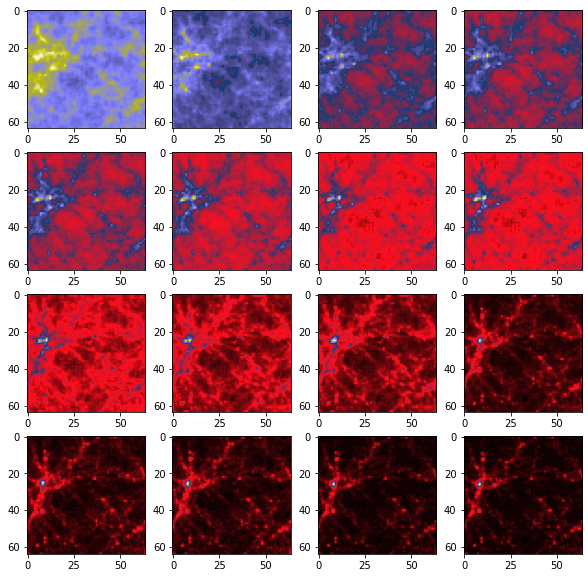

In [8]:
# High res simulation
figure(figsize=[10,10])
for i in range(16):
    subplot(4,4,i+1)
    imshow(cic_paint(jnp.zeros(mesh_shape), poss[::2][i]).sum(axis=0), cmap='gist_stern', vmin=0)

In [9]:
k, pk_ref = power_spectrum(
      compensate_cic(cic_paint(jnp.zeros(mesh_shape), poss[-1])),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)

k, pk_i = power_spectrum(
      compensate_cic(cic_paint(jnp.zeros(mesh_shape), resi[0][-1])),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)

/local/home/dl264294/.local/lib/python3.8/site-packages/jax/_src/lax/lax.py:487: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)


Text(0, 0.5, '$P(k)$')

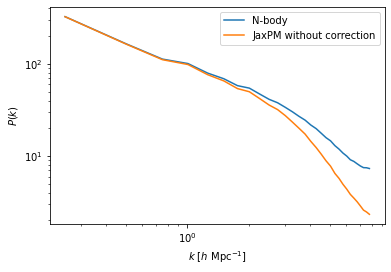

In [10]:
loglog(k,pk_ref, label='N-body')
loglog(k,pk_i, label='JaxPM without correction')
legend()
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$")

In [11]:
model = hk.without_apply_rng(hk.transform(lambda x,a : NeuralSplineFourierFilter(n_knots=16, latent_size=32)(x,a)))
import pickle
params = pickle.load( open( "correction_params/camels_25_64_CV_0_lambda1_01.params", "rb" ) )

In [12]:
def neural_nbody_ode(state, a, cosmo, params):
    """
    state is a tuple (position, velocities)
    """
    pos, vel = state
    
    kvec = fftk(mesh_shape)

    delta = cic_paint(jnp.zeros(mesh_shape), pos)
    
    delta_k = jnp.fft.rfftn(delta)
    
    # Computes gravitational potential
    pot_k = delta_k * laplace_kernel(kvec) * longrange_kernel(kvec, r_split=0)
    
    # Apply a correction filter
    kk = jnp.sqrt(sum((ki/pi)**2 for ki in kvec))
    pot_k = pot_k *(1. + model.apply(params, kk, jnp.atleast_1d(a)))
    
    # Computes gravitational forces
    forces = jnp.stack([cic_read(jnp.fft.irfftn(gradient_kernel(kvec, i)*pot_k), pos) 
                      for i in range(3)],axis=-1)
    
    forces = forces * 1.5 * cosmo.Omega_m

    # Computes the update of position (drift)
    dpos = 1. / (a**3 * jnp.sqrt(jc.background.Esqr(cosmo, a))) * vel
    
    # Computes the update of velocity (kick)
    dvel = 1. / (a**2 * jnp.sqrt(jc.background.Esqr(cosmo, a))) * forces
    
    return dpos, dvel

In [13]:
res = odeint(neural_nbody_ode, [poss[0], vels[0]], jnp.array(scales), cosmo, params, rtol=1e-5, atol=1e-5)


/tmp/ipykernel_418459/1752112647.py:17: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  kk = jnp.sqrt(sum((ki/pi)**2 for ki in kvec))


In [14]:
k, pk_ref = power_spectrum(
      (cic_paint(jnp.zeros(mesh_shape), poss[-1])),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)

k, pk_i = power_spectrum(
      (cic_paint(jnp.zeros(mesh_shape), resi[0][-1])),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)

k, pk_c = power_spectrum(
      (cic_paint(jnp.zeros(mesh_shape), res[0][-1])),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)


k, cross_c = cross_correlation_coefficients(
      (cic_paint(jnp.zeros(mesh_shape), poss[-1])),
      (cic_paint(jnp.zeros(mesh_shape), res[0][-1])),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)


k, cross_i = cross_correlation_coefficients(
      (cic_paint(jnp.zeros(mesh_shape), poss[-1])),
      (cic_paint(jnp.zeros(mesh_shape), resi[0][-1])),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)

/local/home/dl264294/.local/lib/python3.8/site-packages/jax/_src/lax/lax.py:487: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)


In [15]:
params_pgd = pickle.load( open( "correction_params/camels_25_64_pkloss_PGD_CV_0.params", "rb" ) )


In [16]:
def PGD_kernel(kvec, kl, ks):

  kk = sum(ki**2 for ki in kvec)
  kl2 = kl**2
  ks4 = ks**4
  mask = (kk == 0).nonzero()
  kk[mask] = 1
  v = jnp.exp(-kl2 / kk) * jnp.exp(-kk**2 / ks4)
  imask = (~(kk == 0)).astype(int)
  v *= imask
  return v

def pgd_correction(pos, cosmo, params):
    """
    state is a tuple (position, velocities)
    """

    
    kvec = fftk(mesh_shape)

    delta = cic_paint(jnp.zeros(mesh_shape), pos)
    alpha, kl, ks = params
    delta_k = jnp.fft.rfftn(delta)
    PGD_range=PGD_kernel(kvec, kl, ks)
    
    pot_k_pgd=(delta_k * laplace_kernel(kvec))*PGD_range

    forces_pgd= jnp.stack([cic_read(jnp.fft.irfftn(gradient_kernel(kvec, i)*pot_k_pgd), pos) 
                      for i in range(3)],axis=-1)
    
    dpos_pgd = forces_pgd*alpha
   
    return dpos_pgd

In [18]:
k, pk_pgd = power_spectrum(
      (cic_paint(jnp.zeros(mesh_shape), resi[0][-1]+pgd_correction(resi[0][-1],cosmo, params_pgd))),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)



k, cross_pgd = cross_correlation_coefficients(
      (cic_paint(jnp.zeros(mesh_shape), poss[-1])),
      (cic_paint(jnp.zeros(mesh_shape), resi[0][-1]+pgd_correction(resi[0][-1],cosmo, params_pgd))),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)

/tmp/ipykernel_418459/1135245045.py:3: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  kk = sum(ki**2 for ki in kvec)


In [19]:
import cmasher as cmr
import matplotlib.colors as colors

cmap = cmr.eclipse  
col = cmr.eclipse([0.,0,0.55,0.85]) 

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0., vmax=1))


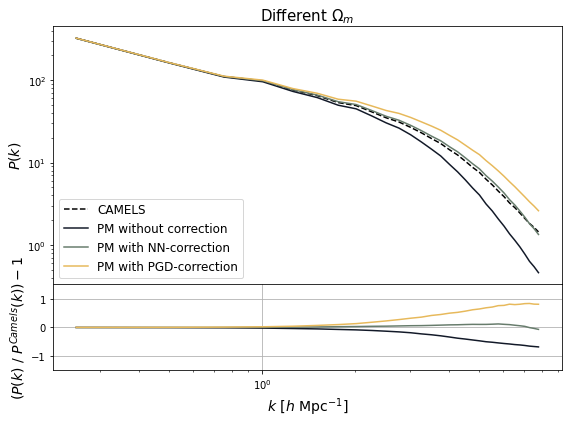

In [20]:
from matplotlib import gridspec
col = cmr.eclipse([0.,0.13,0.55,0.85])  
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1],hspace=0) 
ax0 = plt.subplot(gs[0])
ax0.loglog(k, pk_ref,'--',  label='CAMELS',color=col[0])
ax0.loglog(k, pk_i,label='PM without correction',color=col[1])
ax0.loglog(k, pk_c,  label='PM with NN-correction',color=col[2])
ax0.loglog(k, pk_pgd,  label='PM with PGD-correction',color=col[3])
ax0.label_outer()
plt.legend(fontsize='large')
ax0.set_xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]",fontsize=14)
ax0.set_ylabel(r"$P(k)$", fontsize=14)
ax1 = plt.subplot(gs[1])
ax1.semilogx(k, (pk_i/pk_ref)-1,label='PM without correction',color=col[1])
ax1.semilogx(k, (pk_c/pk_ref)-1,label='PM with NN-correction',color=col[2])   
ax1.semilogx(k, (pk_pgd/pk_ref)-1,label='PM with PGD-correction',color=col[3]) 
ax1.set_ylabel(r"$ (P(k) \ / \ P^{Camels}(k))-1$",fontsize=14)
ax1.set_xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]",fontsize=14)
ax0.set_title('Different $\Omega_m$',fontsize=15)
ax1.set_ylim(-1.5,1.5)
plt.tight_layout()
plt.grid(True)
plt.savefig('../figures/camels_comparison_residual_diffomega_1P_1_n5.pdf')

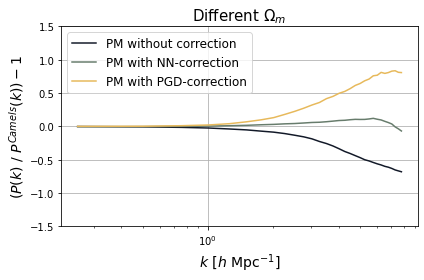

In [25]:

semilogx(k, (pk_i/pk_ref)-1,label='PM without correction',color=col[1])
semilogx(k, (pk_c/pk_ref)-1,label='PM with NN-correction',color=col[2])   
semilogx(k, (pk_pgd/pk_ref)-1,label='PM with PGD-correction',color=col[3]) 
ylabel(r"$ (P(k) \ / \ P^{Camels}(k))-1$",fontsize=14)
xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]",fontsize=14)
title('Different $\Omega_m$',fontsize=15)
ylim(-1.5,1.5)
plt.grid(True)
plt.legend(fontsize='large')
plt.tight_layout()
plt.savefig('../figures/camels_residual_diffomega_1P_1_n5.pdf')

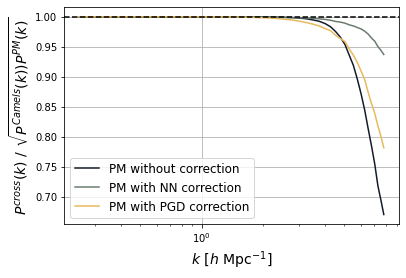

In [21]:
semilogx(k, cross_i/np.sqrt(pk_ref*pk_i),label='PM without correction',color=col[1])
semilogx(k, cross_c/np.sqrt(pk_ref*pk_c),label='PM with NN correction',color=col[2])
semilogx(k, cross_pgd/np.sqrt(pk_ref*pk_pgd),label='PM with PGD correction',color=col[3])    
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]",fontsize=14)
plt.axhline(y=1,color=col[0],linestyle='dashed')
plt.ylabel(r"$ P^{cross}(k) \ / \ \sqrt{P^{Camels}(k))P^{PM}(k)}$",fontsize=14)
plt.grid(True)
legend(fontsize='large')
plt.savefig('../figures/cross_corr_diffomega_1P_1_n5.pdf')